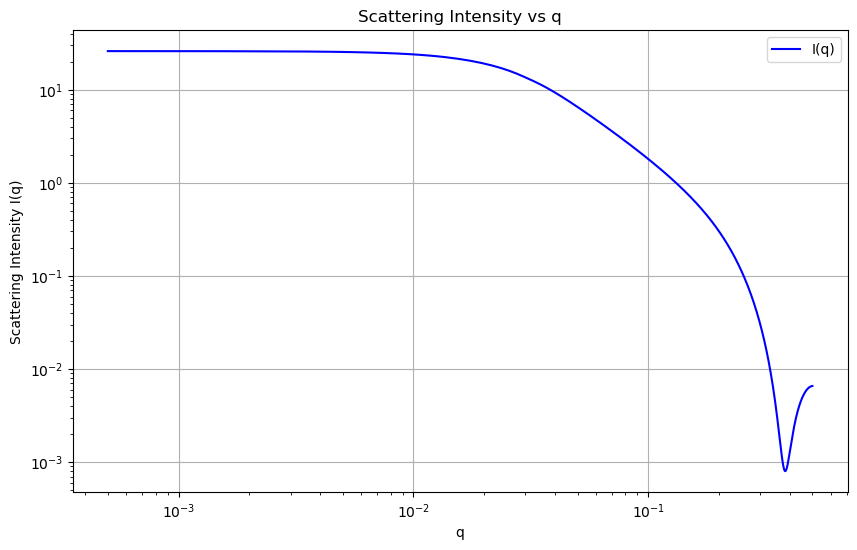

In [11]:
# WLC model from Pedersen 1996

import math
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.optimize import curve_fit

# Flexible cylinder from flexible_cylinder.c

def form_volume(length, kuhn_length, radius):
    """
    Compute the form volume.
    """
    return 1.0


def vi(length, kuhn_length):
    en_rg_long = Rgsquare(length, kuhn_length)
    en_rg_short = Rgsquareshort(length, kuhn_length)
    
    if length > 4 * kuhn_length:  # L > 4*b : Longer Chains
            en_rg = en_rg_long
    else:  # L <= 4*b : Shorter Chains
            en_rg = en_rg_short
            return en_rg
    A_2 = 4 * math.pi**1.5 * 6.022e23 * en_rg**3 * 0.23
    para_X = 16 * A_2
    return para_X
    
    
def si(x):
    if x == 0:
        return 0  
    else:
        Si_function, _ = integrate.quad(lambda t: np.sin(t) / t if t != 0 else 1, 1e-10, x)
        return Si_function
    
#cq for semi-flexible polymer
def cq_sfp(q, length):
    
    qL = q * length
    
    ffrod = 2 * si(qL) - (2*math.sin(qL)/(qL))**2
    
    return ffrod


    
# cq for polyelectrolytes
def cq_pel(q, kuhn_length, radius):
    
    sigma = math.expm1(radius / (2 * kuhn_length)) / kuhn_length
    qRc = q * radius
    
    return (math.sin(qRc) / qRc) * math.expm1 (-q**2 * sigma**2)


# Worm-Like Chain Model
def Rgsquare(L, b):
    x = L / b
    # Use Horner's method to evaluate Pedersen eq 15:
    #     alpha^2 = [1.0 + (x/3.12)^2 + (x/8.67)^3] ^ (0.176/3)
    alphasq = math.pow(1.0 + x * x * (1.027284681130835e-01 + 1.534414548417740e-03 * x),
                       5.866666666666667e-02)
    return alphasq * L * b / 6.0

def Rgsquareshort(L, b):
    r = b / L  # = 1/n_b in Pedersen ref.
    return Rgsquare(L, b) * (1.0 + r * (-1.5 + r * (1.5 + r * 0.75 * math.expm1(-2.0 / r))))

def w_WR(x):
    # Pedersen eq. 16:
    #    w = [1 + tanh((x-C4)/C5)]/2
    C4 = 1.523
    C5 = 0.1477
    return 0.5 + 0.5 * math.tanh((x - C4) / C5)

def Sdebye(qsq):
    # Define DEBYE_CUTOFF based on FLOAT_SIZE
    DEBYE_CUTOFF = 0.25 if sys.float_info.max_exp > 4 else 1.0  # 1e-15 error for >4, 4e-7 error otherwise

    if qsq < DEBYE_CUTOFF:
        x = qsq
        # Mathematica: PadeApproximant[2*Exp[-x^2] + x^2-1)/x^4, {x, 0, 8}]
        A1 = 1.0 / 15.0
        A2 = 1.0 / 60.0
        A3 = 0.0
        A4 = 1.0 / 75600.0
        B1 = 2.0 / 5.0
        B2 = 1.0 / 15.0
        B3 = 1.0 / 180.0
        B4 = 1.0 / 5040.0
        return ((((A4 * x + A3) * x + A2) * x + A1) * x + 1.0) / ((((B4 * x + B3) * x + B2) * x + B1) * x + 1.0)
    else:
        return 2.0 * (math.expm1(-qsq) + qsq) / (qsq * qsq)
    
def a_long(q, L, b):
    p1 = 4.12
    p2 = 4.42
    q0 = 3.1

    # Constants C1, ..., C5 derived from least squares fit (Pedersen, eq 13,16)
    C1 = 1.22
    C2 = 0.4288
    C3 = -1.651
    C4 = 1.523
    C5 = 0.1477
    miu = 0.585

    C = 3.06 * pow(L / b, -0.44) if L / b > 10.0 else 1.0
    r2 = Rgsquare(L, b)
    r = math.sqrt(r2)
    qr_b = q0 * r / b
    qr_b_sq = qr_b * qr_b
    qr_b_4 = qr_b_sq * qr_b_sq
    qr_b_miu = pow(qr_b, -1.0 / miu)
    em1_qr_b_sq = math.expm1(-qr_b_sq)
    sech2 = 1.0 / math.cosh((qr_b - C4) / C5) ** 2
    w = w_WR(qr_b)

    t1 = pow(q0, 1.0 + p1 + p2) / (b * (p1 - p2))
    t2 = C / (15.0 * L) * (
        +14.0 * b * b * em1_qr_b_sq / (q0 * qr_b_sq)
        + 2.0 * q0 * r2 * math.exp(-qr_b_sq) * (11.0 + 7.0 / qr_b_sq)
    )
    t11 = ((C3 * qr_b_miu + C2) * qr_b_miu + C1) * qr_b_miu
    t3 = r * sech2 / (2.0 * C5) * t11
    t4 = r * (em1_qr_b_sq + qr_b_sq) * sech2 / (C5 * qr_b_4)
    t5 = -4.0 * r * qr_b * em1_qr_b_sq / qr_b_4 * (1.0 - w)
    t10 = 2.0 * (em1_qr_b_sq + qr_b_sq) / qr_b_4 * (1.0 - w)  # =Sdebye*(1-w)
    t6 = 4.0 * b / q0 * t10
    t7 = r * ((-3.0 * C3 * qr_b_miu - 2.0 * C2) * qr_b_miu - 1.0 * C1) * qr_b_miu / (miu * qr_b)
    t9 = C * b / L * (4.0 - math.exp(-qr_b_sq) * (11.0 + 7.0 / qr_b_sq) + 7.0 / qr_b_sq) / 15.0
    t12 = b * b * math.pi / (L * q0 * q0) + t2 + t3 - t4 + t5 - t6 + t7 * w
    t13 = -b * math.pi / (L * q0) + t9 + t10 + t11 * w

    a1 = pow(q0, p1) * t13 - t1 * pow(q0, -p2) * (t12 + b * p1 / q0 * t13)
    a2 = t1 * pow(q0, -p1) * (t12 + b * p1 / q0 * t13)

    ans = a1 * pow(q * b, -p1) + a2 * pow(q * b, -p2) + math.pi / (q * L)
    return ans

def _short(r2, exp_qr_b, L, b, p1short, p2short, q0):
    qr2 = q0 * q0 * r2
    b3 = b * b * b
    q0p = pow(q0, -4.0 + p1short)

    yy = 1.0 / (L * r2 * r2) * b / exp_qr_b * q0p * (
        8.0 * b3 * L
        - 8.0 * b3 * exp_qr_b * L
        + 2.0 * b3 * exp_qr_b * L * p2short
        - 2.0 * b * exp_qr_b * L * p2short * qr2
        + 4.0 * b * exp_qr_b * L * qr2
        - 2.0 * b3 * L * p2short
        + 4.0 * b * L * qr2
        - math.pi * exp_qr_b * qr2 * q0 * r2
        + math.pi * exp_qr_b * p2short * qr2 * q0 * r2
    )

    return yy


def a_short(qp, L, b, q0):
    p1short = 5.36
    p2short = 5.62

    r2 = Rgsquareshort(L, b)
    exp_qr_b = math.exp(r2 * (q0 / b) ** 2)
    pdiff = p1short - p2short
    a1 = _short(r2, exp_qr_b, L, b, p1short, p2short, q0) / pdiff
    a2 = -_short(r2, exp_qr_b, L, b, p2short, p1short, q0) / pdiff
    ans = a1 * pow(qp * b, -p1short) + a2 * pow(qp * b, -p2short) + math.pi / (qp * L)
    return ans

def Sexv(q, L, b):
    # Pedersen eq 13, corrected by Chen eq A.5, swapping w and 1-w
    C1 = 1.22
    C2 = 0.4288
    C3 = -1.651
    miu = 0.585
    qr = q * math.sqrt(Rgsquare(L, b))
    qr_miu = pow(qr, -1.0 / miu)
    w = w_WR(qr)
    t10 = Sdebye(qr * qr) * (1.0 - w)
    t11 = ((C3 * qr_miu + C2) * qr_miu + C1) * qr_miu

    return t10 + w * t11

def Sexv_new(q, L, b):
    # Modified by Yun on Oct. 15
    qr = q * math.sqrt(Rgsquare(L, b))
    qr2 = qr * qr
    C = 3.06 * pow(L / b, -0.44) if L / b > 10.0 else 1.0
    t9 = C * b / L * (4.0 - math.exp(-qr2) * (11.0 + 7.0 / qr2) + 7.0 / qr2) / 15.0

    Sexv_orig = Sexv(q, L, b)

    # calculating the derivative to decide on the correction (cutoff) term?
    # Note: this is modified from WRs original code
    del_factor = 1.05
    qdel = (Sexv(q * del_factor, L, b) - Sexv_orig) / (q * (del_factor - 1.0))

    if qdel < 0:
        # branch A1
        return t9 + Sexv_orig
    else:
        # branch A2
        w = w_WR(qr)
        t10 = Sdebye(qr2) * (1.0 - w)
        return t9 + t10
    
def Sk_WR(q, L, b):
    Rg_short = math.sqrt(Rgsquareshort(L, b))
    q0short = max(1.9 / Rg_short, 3.0)

    if L > 4 * b:  # L > 4*b : Longer Chains
        if q * b <= 3.1:
            ans = Sexv_new(q, L, b)
        else:  # q * b > 3.1
            ans = a_long(q, L, b)
    else:  # L <= 4*b : Shorter Chains
        if q * b <= q0short:  # q * b <= fmax(1.9/Rg_short, 3)
            # Note that q0short is usually 3, but it will be greater than 3
            # small enough b, depending on the L/b ratio:
            #     L/b == 1 => b < 2.37
            #     L/b == 2 => b < 1.36
            #     L/b == 3 => b < 1.00
            #     L/b == 4 => b < 0.816
            # 2017-10-01 pkienzle: moved low q approximation into Sdebye()
            ans = Sdebye((q * Rg_short) ** 2)
        else:  # q * b > max(1.9/Rg_short, 3)
            ans = a_short(q, L, b, q0short)

    return ans

# Some mathematics from sas_J1.c

RPJ1 = [
    -8.99971225705559398224E8,
    4.52228297998194034323E11,
    -7.27494245221818276015E13,
    3.68295732863852883286E15,
    0.0,
    0.0,
    0.0,
    0.0
]

RQJ1 = [
    6.20836478118054335476E2,
    2.56987256757748830383E5,
    8.35146791431949253037E7,
    2.21511595479792499675E10,
    4.74914122079991414898E12,
    7.84369607876235854894E14,
    8.95222336184627338078E16,
    5.32278620332680085395E18
]

PPJ1 = [
    7.62125616208173112003E-4,
    7.31397056940917570436E-2,
    1.12719608129684925192E0,
    5.11207951146807644818E0,
    8.42404590141772420927E0,
    5.21451598682361504063E0,
    1.00000000000000000254E0,
    0.0
]

PQJ1 = [
    5.71323128072548699714E-4,
    6.88455908754495404082E-2,
    1.10514232634061696926E0,
    5.07386386128601488557E0,
    8.39985554327604159757E0,
    5.20982848682361821619E0,
    9.99999999999999997461E-1,
    0.0
]

QPJ1 = [
    5.10862594750176621635E-2,
    4.98213872951233449420E0,
    7.58238284132545283818E1,
    3.66779609360150777800E2,
    7.10856304998926107277E2,
    5.97489612400613639965E2,
    2.11688757100572135698E2,
    2.52070205858023719784E1
]

QQJ1 = [
    7.42373277035675149943E1,
    1.05644886038262816351E3,
    4.98641058337653607651E3,
    9.56231892404756170795E3,
    7.99704160447350683650E3,
    2.82619278517639096600E3,
    3.36093607810698293419E2,
    0.0
]

JPJ1 = [
    -4.878788132172128E-9,
    6.009061827883699E-7,
    -4.541343896997497E-5,
    1.937383947804541E-3,
    -3.405537384615824E-2,
    0.0,
    0.0,
    0.0
]

MO1J1 = [
    6.913942741265801E-2,
    -2.284801500053359E-1,
    3.138238455499697E-1,
    -2.102302420403875E-1,
    5.435364690523026E-3,
    1.493389585089498E-1,
    4.976029650847191E-6,
    7.978845453073848E-1
]

PH1J1 = [
    -4.497014141919556E1,
    5.073465654089319E1,
    -2.485774108720340E1,
    7.222973196770240E0,
    -1.544842782180211E0,
    3.503787691653334E-1,
    -1.637986776941202E-1,
    3.749989509080821E-1
]

def cephes_j1(x):
    """
    Compute the Bessel function of the first kind of order one, J1(x).
    """
    Z1 = 1.46819706421238932572E1
    Z2 = 4.92184563216946036703E1

    # 2017-05-18 PAK - mathematica and mpmath use J1(-x) = -J1(x)
    if x < 0:
        abs_x = -x
        sign_x = -1.0
    else:
        abs_x = x
        sign_x = 1.0

    if abs_x <= 5.0:
        z = abs_x * abs_x
        w = polevl(z, RPJ1, 3) / p1evl(z, RQJ1, 8)
        w = w * abs_x * (z - Z1) * (z - Z2)
        return sign_x * w

    w = 5.0 / abs_x
    z = w * w
    p = polevl(z, PPJ1, 6) / polevl(z, PQJ1, 6)
    q = polevl(z, QPJ1, 7) / p1evl(z, QQJ1, 7)

    # 2017-05-19 PAK improve accuracy using trig identities
    # original:
    #    const double THPIO4 =  2.35619449019234492885;
    #    const double SQ2OPI = 0.79788456080286535588;
    #    double sin_xn, cos_xn;
    #    SINCOS(abs_x - THPIO4, sin_xn, cos_xn);
    #    p = p * cos_xn - w * q * sin_xn;
    #    return( sign_x * p * SQ2OPI / sqrt(abs_x) );
    # expanding p*cos(a - 3 pi/4) - wq sin(a - 3 pi/4)
    #    [ p(sin(a) - cos(a)) + wq(sin(a) + cos(a)) / sqrt(2)
    # note that sqrt(1/2) * sqrt(2/pi) = sqrt(1/pi)
    SQRT1_PI = 0.56418958354775628
    sin_x = math.sin(abs_x)
    cos_x = math.cos(abs_x)
    p = p * (sin_x - cos_x) + w * q * (sin_x + cos_x)
    return sign_x * p * SQRT1_PI / math.sqrt(abs_x)

def cephes_j1f(xx):
    """
    Compute the Bessel function of the first kind of order one, J1(x) for float input.
    """
    Z1 = 1.46819706421238932572E1

    # 2017-05-18 PAK - mathematica and mpmath use J1(-x) = -J1(x)
    x = xx
    if x < 0:
        x = -xx

    if x <= 2.0:
        z = x * x
        p = (z - Z1) * x * polevl(z, JPJ1, 4)
        return -p if xx < 0 else p

    q = 1.0 / x
    w = math.sqrt(q)

    p = w * polevl(q, MO1J1, 7)
    w = q * q

    # 2017-05-19 PAK improve accuracy using trig identities
    # original:
    #    const float THPIO4F =  2.35619449019234492885;    /* 3*pi/4 */
    #    xn = q * polevl( w, PH1J1, 7) - THPIO4F;
    #    p = p * cos(xn + x);
    #    return( xx < 0. ? -p : p );
    # expanding cos(a + b - 3 pi/4) is
    #    [sin(a)sin(b) + sin(a)cos(b) + cos(a)sin(b)-cos(a)cos(b)] / sqrt(2)
    xn = q * polevl(w, PH1J1, 7)
    sin_xn, cos_xn = math.sin(xn), math.cos(xn)
    sin_x, cos_x = math.sin(x), math.cos(x)
    p *= math.sqrt(0.5) * (sin_xn * (sin_x + cos_x) + cos_xn * (sin_x - cos_x))

    return -p if xx < 0 else p

# Finally J1c function that equals 2*J1(x)/x
def sas_2J1x_x(x):
    return (2.0 * cephes_j1(x) / x) if x != 0.0 else 1.0


# Some mathematics from polevl.c
def polevl(x, coef, N):
    """
    Evaluate polynomial of degree N with given coefficients.
    """
    ans = coef[0]
    for i in range(1, N + 1):
        ans = ans * x + coef[i]
    return ans

def p1evl(x, coef, N):
    """
    Evaluate polynomial of degree N when the coefficient of x^N is 1.0.
    """
    ans = x + coef[0]
    for i in range(1, N):
        ans = ans * x + coef[i]
    return ans

def Iq(q, length, kuhn_length, radius, sld, solvent_sld, background, conc, wamw):
    """
    Compute the scattering intensity.
    """
    num_density = conc / wamw
    contrast = sld - solvent_sld
    cross_section = sas_2J1x_x(q * radius)
    volume = math.pi * radius * radius * length
    P_wlc = Sk_WR(q, length, kuhn_length)
    dir_cor = cq_sfp(q, length)
    parax = vi(length, kuhn_length) * conc / wamw
    parav = 0.125*(9 * parax - 2 + (2 * math.log(1 + parax))/parax) * math.expm1(0.25 * (1 / parax + (1 - 1/parax**2) * math.log(1 + parax)))
    return 1e-4 * volume * (contrast * cross_section)**2 * P_wlc + background



if __name__ == "__main__":
    # Example usage of Iq_fc
    q_values = np.linspace(0.0005, 0.5, 500)
    conc = 2.4e-31 # mol A-3
    wamw = 45000 # g mol-1
    length = 488
    kuhn_length = 25.0
    radius = 10
    sld = 10.72
    solvent_sld = 9.42
    background = 0.0008
    intensities = [Iq(q, length, kuhn_length, radius, sld, solvent_sld, background, conc, wamw) for q in q_values]
    #print(f"Scattering intensity I(q) at q={q}: {intensity}")
    
plt.figure(figsize=(10, 6))
plt.plot(q_values, intensities, label='I(q)', color='b')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('q')
plt.ylabel('Scattering Intensity I(q)')
plt.title('Scattering Intensity vs q')
plt.grid(True)
plt.legend()
plt.show()




